In [1]:
# dev convenience
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import PATHS
import config
import utils
import custom_metrics
from sklearn.metrics import auc, precision_recall_curve, roc_auc_score

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
configs = config.nb_configs

# os.environ["WANDB_SILENT"] = "True"
os.environ["WANDB_NOTEBOOK_NAME"] = "07-model-evaluation.ipynb"

import wandb
print("W&B: ", wandb.__version__)
wandb.login()

PROJECT_NAME = "bagls-sh-project"

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find 07-model-evaluation.ipynb.


W&B:  0.13.5


wandb: Currently logged in as: miked. Use `wandb login --relogin` to force relogin


In [3]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow import keras
from tensorflow.keras import metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14630021161911500667
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10925703168
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 6868592658634500236
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 10925703168
locality {
  bus_id: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 2039024104530833085
physical_device_desc: "device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:08:00.0, compute capability: 6.1"
, name: "/device:GPU:2"
device_type: "GPU"
memory_limit: 10925703168
locality {
  bus_id: 2
  numa_node: 1
  links {
    link {
      device_id: 3
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 1

2022-12-04 10:49:58.863477: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-04 10:50:01.814278: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:0 with 10419 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1
2022-12-04 10:50:01.815239: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:1 with 10419 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:08:00.0, compute capability: 6.1
2022-12-04 10:50:01.815968: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:2 with 10419 MB memory:  -> device: 2, name: NVIDIA GeForce GTX 1080 Ti, pci

## Create bootstraps of the `test` set

In [4]:
# generator
test_datagen = ImageDataGenerator(
    preprocessing_function=None, 
    rescale=configs["rescale"],
)

In [5]:
test_dir = "../test/test"
num_bootstrap = 10 # bootstrap sets
datasets, labels_list, = [], []
df_list = []

for i in range(num_bootstrap):
    # get boostrap dataframes
    csv_path = os.path.join(PATHS.bootstrap_dir, f"test-{i}.csv")
    df = utils.prepare_df(csv_path)
    
    # get labels 1 unhealthy, 0 healthy
    labels_list.append((df["is_healthy"]==False).astype(int))    
    test_dataset = test_datagen.flow_from_dataframe(
        df, directory=test_dir, 
        x_col='filename', y_col='class',
        target_size=configs["image_size"],
        color_mode=configs["cmap"],
        classes=configs["class_names"],
        class_mode=configs["label_mode"],
        batch_size=configs["batch_size"],
        interpolation=configs["interpol"],
        validate_filenames=True,
        shuffle=False,
    )
    # log df
    df_list.append(df)
    datasets.append(test_dataset)

Found 2300 validated image filenames belonging to 2 classes.
Found 2300 validated image filenames belonging to 2 classes.
Found 2300 validated image filenames belonging to 2 classes.
Found 2300 validated image filenames belonging to 2 classes.
Found 2300 validated image filenames belonging to 2 classes.
Found 2300 validated image filenames belonging to 2 classes.
Found 2300 validated image filenames belonging to 2 classes.
Found 2300 validated image filenames belonging to 2 classes.
Found 2300 validated image filenames belonging to 2 classes.
Found 2300 validated image filenames belonging to 2 classes.


## Load Models

In [6]:
# initialize empty values
models = {
    'convnet_from_scratch': None,
    'DenseNet121': None,
    'ResNet50': None,
    'InceptionV3': None, 
    'InceptionResNetV2': None,
}

In [7]:
JOB_TYPE = 'get_model'

for model_name in models:
    run = wandb.init(project=PROJECT_NAME, job_type=JOB_TYPE, 
                     name=model_name)
    model_at = run.use_artifact("model-" + model_name + ":latest")
    model_dir = model_at.download()
    
    run.finish()
    
    model = keras.models.load_model(model_dir, compile=False)
    # model = keras.models.load_model(
    #     model_dir, custom_objects=metrics_dict, compile=False)
    model.trainable = False
    model.compile()
    model.trainable
    models[model_name] = model

wandb: Downloading large artifact model-convnet_from_scratch:latest, 111.03MB. 4 files... 
wandb:   4 of 4 files downloaded.  
Done. 0:0:0.5


2022-12-04 10:50:27.385998: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10419 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1
2022-12-04 10:50:27.387076: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10419 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:08:00.0, compute capability: 6.1
2022-12-04 10:50:27.388097: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 10419 MB memory:  -> device: 2, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:84:00.0, compute capability: 6.1
2022-12-04 10:50:27.389100: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 10419 MB memory:  -> device: 3, name: NVIDIA GeForce

wandb:   4 of 4 files downloaded.  


wandb: Downloading large artifact model-ResNet50:latest, 106.03MB. 4 files... 
wandb:   4 of 4 files downloaded.  
Done. 0:0:0.5


wandb: Downloading large artifact model-InceptionV3:latest, 101.47MB. 4 files... 
wandb:   4 of 4 files downloaded.  
Done. 0:0:0.4


wandb: Downloading large artifact model-InceptionResNetV2:latest, 231.20MB. 4 files... 
wandb:   4 of 4 files downloaded.  
Done. 0:0:0.6


## Evaluate models

### Inspect ROC and PR curves

100%|██████████| 10/10 [02:11<00:00, 13.15s/it]


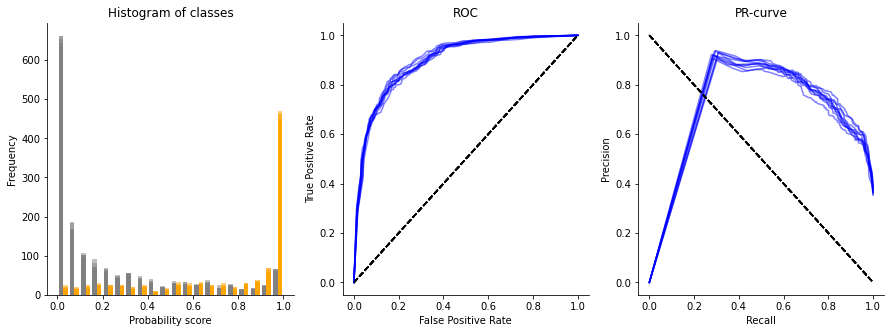

In [17]:
model_name = 'InceptionResNetV2'
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax = ax.flatten()

for i in tqdm(range(num_bootstrap)):
    true = labels_list[i]
    preds = models[model_name].predict(datasets[i])
    results = utils.get_results(true, preds, num_thresh=100, class_index=1) # unhealthy
    ax = utils.plot_results(ax, *results, true)
plt.show()

In [18]:
# log to wandb
run = wandb.init(
    project=PROJECT_NAME, job_type='log_curves', 
    name=f'curves-logging'
)
run.log({f'{model_name}-curves': wandb.Image(fig)})
run.finish()

### Calibration based on ROC and PR

In [19]:
def best_roc_thresh(true, pred_proba, num_thresh):
    fprs, tprs, thresh_arr = utils.get_roc(
        true, pred_proba, num_thresh, return_thresh_arr=True)
    fprs  = np.array(fprs)
    tprs  = np.array(tprs)    
    # maximize product of tpr and 1 - fpr
    best_thresh = thresh_arr[np.argmax((1 - fprs) * tprs)]
    
    print(f"Best ROC thresh: {best_thresh:.4f}")
    return best_thresh
    
def best_pr_thresh(true, pred_proba, num_thresh):
    rs, ps, thresh_arr = utils.get_pr(
        true, pred_proba, num_thresh, return_thresh_arr=True)
    rs  = np.array(rs)
    ps  = np.array(ps)    
    # maximize product of r and p
    best_thresh = thresh_arr[np.argmax(rs*ps)]
    
    print(f"Best PR thresh: {best_thresh:.4f}")
    return best_thresh

In [20]:
# test calibration functions
class_index = 1 # unhealthy
i = 0 # one bootstrap set
num_thresh = 200
true = labels_list[i]
preds = models[model_name].predict(datasets[i])

# get proba for class of interest : unhealthy
pred_proba = utils.get_class_proba(preds, class_index=class_index)
roc_thresh = best_roc_thresh(true, pred_proba, num_thresh)
pr_thresh = best_pr_thresh(true, pred_proba, num_thresh)

Best ROC thresh: 0.4573
Best PR thresh: 0.4573


### Get Calibrated Results

In [21]:
# read actual test set
csv_path = os.path.join(PATHS.test_meta)
df = utils.prepare_df(csv_path)
test_dataset = test_datagen.flow_from_dataframe(
        df, directory=test_dir, 
        x_col='filename', y_col='class',
        target_size=configs["image_size"],
        color_mode=configs["cmap"],
        classes=configs["class_names"],
        class_mode=configs["label_mode"],
        batch_size=configs["batch_size"],
        interpolation=configs["interpol"],
        validate_filenames=True,
        shuffle=False,
    )
class_index = 1 # unhealthy
num_thresh = 200

Found 2300 validated image filenames belonging to 2 classes.


In [22]:
# will be used to log all calibrated results from all models
overall_calibrated_metrics = {}
overall_uncalibrated_metrics = {}
results_tables = {}
for name, model in models.items():
    print(f"Currently running {name}")
    true = test_dataset.labels
    preds = model.predict(test_dataset)
    
    # get proba for class of interest : unhealthy
    pred_proba = utils.get_class_proba(preds, class_index=class_index)
    roc_thresh = best_roc_thresh(true, pred_proba, num_thresh)
    temp_df = df.copy()
    temp_df['pred_proba_healthy'] = preds[:, 0]
    temp_df['pred_proba_unhealthy'] = preds[:,1]
    temp_df['uncalibrated_prediction'] = temp_df['pred_proba_unhealthy'].apply(
        lambda x: 'unhealthy' if (x > 0.5) else 'healthy')
    temp_df['calibrated_prediction'] = temp_df['pred_proba_unhealthy'].apply(
        lambda x: 'unhealthy' if (x > roc_thresh) else 'healthy')
    
    run = wandb.init(
        project=PROJECT_NAME, job_type='log_results', 
        name=f'{name}-inference-results-logging', config=configs
    )
    columns = temp_df.columns.tolist()
    results_table = wandb.Table(columns=columns)
    for index, row in temp_df.iterrows():
        results_table.add_data(*row.tolist())
    
    run.log({f'{name}-results-table': results_table})
    run.finish()
    results_tables[name] = temp_df # dict log
    
    # get model overall calibrated metrics
    conf = utils.get_conf(true, pred_proba, thresh=roc_thresh)
    calibrated_temp_metrics = {
        'calibrated_thresh': roc_thresh,
        'ROC-AUC': auc(*utils.get_roc(true, pred_proba, num_thresh)),
        'PR-AUC': auc(*utils.get_pr(true, pred_proba, num_thresh)),
        'recall': utils.get_sensitivity(*conf),
        'FPR': utils.get_fpr(*conf),
        'specificity': utils.get_specificity(*conf),
        'precision': utils.get_ppv(*conf),
        'NPV': utils.get_npv(*conf),
        'f1': utils.get_fbeta(*conf),
        'MCC': utils.get_mcc(*conf),
    }
    
    conf = utils.get_conf(true, pred_proba, thresh=0.5)
    uncalibrated_temp_metrics = {
        'calibrated_thresh': roc_thresh,
        'ROC-AUC': auc(*utils.get_roc(true, pred_proba, num_thresh)),
        'PR-AUC': auc(*utils.get_pr(true, pred_proba, num_thresh)),
        'recall': utils.get_sensitivity(*conf),
        'FPR': utils.get_fpr(*conf),
        'specificity': utils.get_specificity(*conf),
        'precision': utils.get_ppv(*conf),
        'NPV': utils.get_npv(*conf),
        'f1': utils.get_fbeta(*conf),
        'MCC': utils.get_mcc(*conf),
    }
    
    overall_calibrated_metrics[name] = calibrated_temp_metrics
    overall_uncalibrated_metrics[name] = uncalibrated_temp_metrics

Currently running convnet_from_scratch
Best ROC thresh: 0.0754


Currently running DenseNet121
Best ROC thresh: 0.3819


Currently running ResNet50
Best ROC thresh: 0.6533


Currently running InceptionV3
Best ROC thresh: 0.5025


Currently running InceptionResNetV2
Best ROC thresh: 0.5126


In [23]:
run = wandb.init(
    project=PROJECT_NAME, job_type='log_model-metrics', 
    name=f'overall-metrics-logging'
)
calibrated_metrics_df = pd.DataFrame.from_dict(
    overall_calibrated_metrics, orient='index')
calibrated_metrics_df.index.name = 'Model'
calibrated_metrics_df = calibrated_metrics_df.reset_index()

columns = calibrated_metrics_df.columns.tolist()
calibrated_metrics_table = wandb.Table(columns=columns)
for index, row in calibrated_metrics_df.iterrows():
    calibrated_metrics_table.add_data(*row.tolist())

run.log({f'overall-calibrated-metrics-table': calibrated_metrics_table})


uncalibrated_metrics_df = pd.DataFrame.from_dict(
    overall_uncalibrated_metrics, orient='index')
uncalibrated_metrics_df.index.name = 'Model'
uncalibrated_metrics_df = uncalibrated_metrics_df.reset_index()

columns = uncalibrated_metrics_df.columns.tolist()
uncalibrated_metrics_table = wandb.Table(columns=columns)
for index, row in uncalibrated_metrics_df.iterrows():
    uncalibrated_metrics_table.add_data(*row.tolist())

run.log({f'overall-uncalibrated-metrics-table': uncalibrated_metrics_table})

run.finish()

In [24]:
display(uncalibrated_metrics_df)
display(calibrated_metrics_df)

,Model,calibrated_thresh,ROC-AUC,PR-AUC,recall,FPR,specificity,precision,NPV,f1,MCC
0,convnet_from_scratch,0.075377,0.811360,0.574351,0.741176,0.231034,0.768966,0.652850,0.835206,0.652850,0.498977
1,DenseNet121,0.381910,0.794342,0.727024,0.700000,0.201379,0.798621,0.670800,0.819533,0.670800,0.494460
2,ResNet50,0.653266,0.884922,0.570303,0.800000,0.233103,0.766897,0.667976,0.867395,0.667976,0.550908
3,InceptionV3,0.502513,0.850097,0.779555,0.657647,0.093103,0.906897,0.805476,0.818804,0.805476,0.593661
4,InceptionResNetV2,0.512563,0.899001,0.736789,0.810588,0.173103,0.826897,0.732979,0.881618,0.732979,0.625936


,Model,calibrated_thresh,ROC-AUC,PR-AUC,recall,FPR,specificity,precision,NPV,f1,MCC
0,convnet_from_scratch,0.075377,0.811360,0.574351,0.847059,0.264828,0.735172,0.652174,0.891304,0.652174,0.562521
1,DenseNet121,0.381910,0.794342,0.727024,0.736471,0.233103,0.766897,0.649378,0.832335,0.649378,0.492421
2,ResNet50,0.653266,0.884922,0.570303,0.777647,0.196552,0.803448,0.698732,0.860414,0.698732,0.570015
3,InceptionV3,0.502513,0.850097,0.779555,0.657647,0.092414,0.907586,0.806638,0.818917,0.806638,0.594630
4,InceptionResNetV2,0.512563,0.899001,0.736789,0.807059,0.166897,0.833103,0.739224,0.880466,0.739224,0.629843


## Best Model Evaluation

Let's inspect the following:
* True positives: Correct predictions of unhealthy glottis
* False negatives: Predicted healthy but are otherwise unhealthy

In [28]:
# read results csv from wandb
run = wandb.init()
artifact = run.use_artifact(
    f'miked/bagls-sh-project/run-1zqxly6a-InceptionResNetV2resultstable:v0', 
    type='run_table')
artifact_dir = artifact.download()

print(artifact_dir)
run.finish()

wandb:   1 of 1 files downloaded.  


./artifacts/run-1zqxly6a-InceptionResNetV2resultstable:v0


In [29]:
!ls ./artifacts/run-1zqxly6a-InceptionResNetV2resultstable:v0

InceptionResNetV2-results-table.table.json


In [54]:
import json
from glob import glob

path = glob(os.path.join(artifact_dir, "*.json"))[0]
with open(path, 'r') as file:
    data = json.load(file)
data.keys()

dict_keys(['_type', 'column_types', 'columns', 'data', 'ncols', 'nrows'])

In [55]:
df = pd.DataFrame(data=data['data'], columns=data['columns'])
# get all unhealthy
unhealthy_df = df[df['is_healthy']==0]

In [56]:
case_counts = pd.DataFrame()
fn, tp, index_list = [], [], []

for index in unhealthy_df['Subject disorder status'].unique():
    count_fn = (
        (unhealthy_df['Subject disorder status']==index) & 
        (unhealthy_df['calibrated_prediction']=='healthy')
    ).sum()
    count_tp = (
        (unhealthy_df['Subject disorder status']==index) & 
        (unhealthy_df['calibrated_prediction']=='unhealthy')
    ).sum()
    # costmetics: shorten disorder status
    if len(index) > 70:
        index = list(index)
        index.insert(70, "\n")
        index = ''.join(index)
        
    index_list.append(index)
    fn.append(count_fn)
    tp.append(count_tp)
    
case_counts['Disorder']= index_list
case_counts['false-negative (pred-healthy)'] = fn
case_counts['true-positive (pred-unhealthy)'] = tp
case_counts = case_counts.set_index('Disorder')

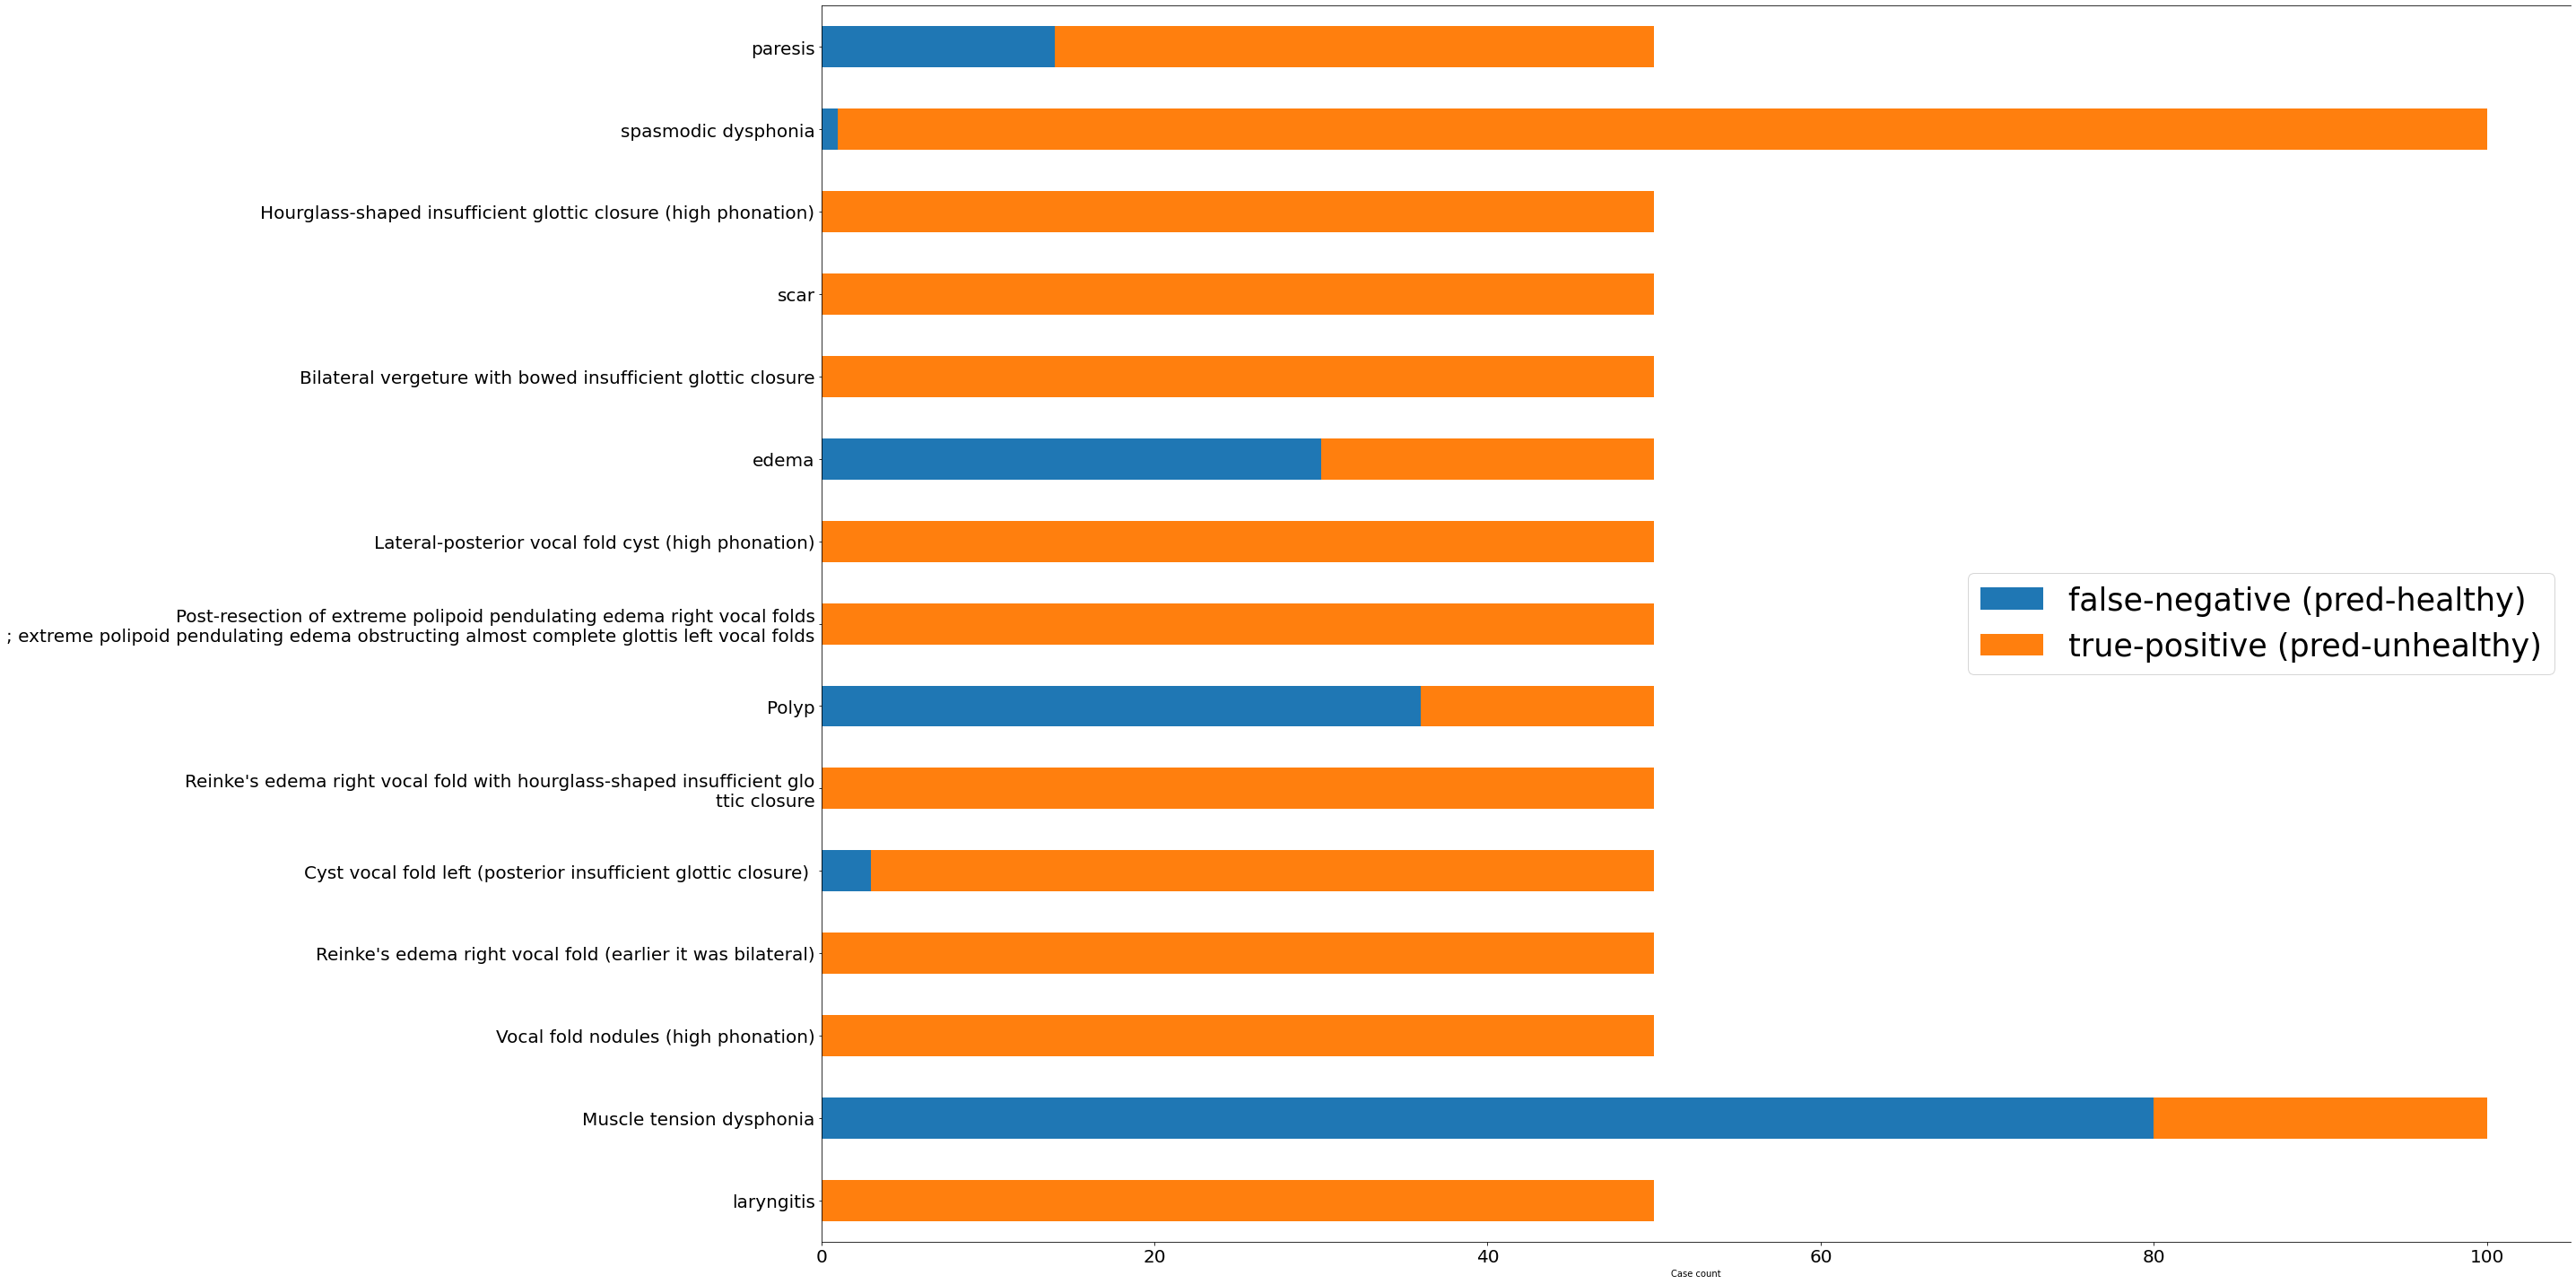

In [57]:
fig, ax = plt.subplots(figsize=(40,20))
case_counts.plot.barh(stacked=True, ax=ax)
ax.spines.right.set_visible(False)
plt.yticks(fontsize=20, rotation=0)
plt.xticks(fontsize=20, rotation=0)
plt.ylabel('')
plt.xlabel('Case count')
plt.legend(fontsize=35)
plt.tight_layout()
plt.show()

In [35]:
# log to wandb
run = wandb.init(
    project=PROJECT_NAME, job_type='log_disorder_eval', 
    name=f'per-disorder-eval'
)
run.log({f'{model_name}-disorder-eval': wandb.Image(fig)})
run.finish()

In [70]:
# focus list: add scar
disorders = ['Muscle tension dysphonia', 'edema', 'Polyp', 'scar']

# try false negatives and true positives
fn_df = df[df['Subject disorder status'].isin(disorders) & 
           (df['calibrated_prediction']=='healthy') &
           (df['class']=='unhealthy')]

fn_test_dataset = test_datagen.flow_from_dataframe(
        fn_df, directory=test_dir, 
        x_col='filename', y_col='class',
        target_size=configs["image_size"],
        color_mode=configs["cmap"],
        classes=configs["class_names"],
        class_mode=configs["label_mode"],
        batch_size=df.shape[0],    
        interpolation=configs["interpol"],
        validate_filenames=True,
        shuffle=False,
)


# try false negatives and true positives
tp_df = df[df['Subject disorder status'].isin(disorders) & 
           (df['calibrated_prediction']=='unhealthy') &
           (df['class']=='unhealthy')]

tp_test_dataset = test_datagen.flow_from_dataframe(
        tp_df, directory=test_dir, 
        x_col='filename', y_col='class',
        target_size=configs["image_size"],
        color_mode=configs["cmap"],
        classes=configs["class_names"],
        class_mode=configs["label_mode"],
        batch_size=df.shape[0],    
        interpolation=configs["interpol"],
        validate_filenames=True,
        shuffle=False,
)

Found 146 validated image filenames belonging to 2 classes.
Found 104 validated image filenames belonging to 2 classes.


In [71]:
import interpretation
model_name = 'InceptionResNetV2'

# prep data
data, labels = fn_test_dataset[0]

# init gradcam class
layer_name = utils.get_last_conv_layer(models[model_name])
cam = interpretation.GradCAM(models[model_name], layer_name)

images, gradcams = [], []
for image, label_arr in zip(data, labels):
    image = np.expand_dims(image, 0)

    # get gradcam heatmap, use pred_index
    heatmap = cam.compute_heatmap(image)

    # append image: remove batch axis, rescale, and convert to uint8
    image = image.reshape(image.shape[1:])
    image = image * 255
    image = image.astype(np.uint8)
    images.append(tf.keras.preprocessing.image.array_to_img(image))

    # overlay gradcam heatmap results to image
    superimposed_img = cam.overlay_heatmap(heatmap, image)

    # append original and gradcam overlay image
    gradcams.append(superimposed_img)

In [72]:
run = wandb.init(
    project=PROJECT_NAME, job_type='log_gradcam', 
    name=f'gradcam_logger'
)

columns = fn_df.columns.tolist() + ['image', 'gradcam_overlay', 'gradcam_layer_used']
gradcam_table = wandb.Table(columns=columns)

for index, (_, data) in enumerate(fn_df.iterrows()):
    row = data.tolist() + [wandb.Image(images[index])] + [wandb.Image(gradcams[index])] + [layer_name]
    gradcam_table.add_data(*row)

run.log({"fn_interpretation" : gradcam_table})
run.finish()

In [73]:
import interpretation
model_name = 'InceptionResNetV2'

# prep data
data, labels = tp_test_dataset[0]

# init gradcam class
layer_name = utils.get_last_conv_layer(models[model_name])
cam = interpretation.GradCAM(models[model_name], layer_name)

images, gradcams = [], []
for image, label_arr in zip(data, labels):
    image = np.expand_dims(image, 0)

    # get gradcam heatmap, use pred_index
    heatmap = cam.compute_heatmap(image)

    # append image: remove batch axis, rescale, and convert to uint8
    image = image.reshape(image.shape[1:])
    image = image * 255
    image = image.astype(np.uint8)
    images.append(tf.keras.preprocessing.image.array_to_img(image))

    # overlay gradcam heatmap results to image
    superimposed_img = cam.overlay_heatmap(heatmap, image)

    # append original and gradcam overlay image
    gradcams.append(superimposed_img)

In [74]:
run = wandb.init(
    project=PROJECT_NAME, job_type='log_gradcam', 
    name=f'gradcam_logger'
)

columns = tp_df.columns.tolist() + ['image', 'gradcam_overlay', 'gradcam_layer_used']
gradcam_table = wandb.Table(columns=columns)

for index, (_, data) in enumerate(tp_df.iterrows()):
    row = data.tolist() + [wandb.Image(images[index])] + [wandb.Image(gradcams[index])] + [layer_name]
    gradcam_table.add_data(*row)

run.log({"tp_interpretation" : gradcam_table})
run.finish()

### Averaging heatmaps

In [52]:
import interpretation
model_name = 'DenseNet121'

# for DenseNet121
layers = ['conv2_block1_concat','conv2_block2_concat','conv2_block3_concat',
          'conv2_block4_concat', 'conv2_block5_concat', 'conv5_block12_concat', 
          'conv5_block13_concat','conv5_block14_concat','conv5_block16_concat']


# prep data
data, labels = tp_test_dataset[0]
heatmap_dict = {}

images, gradcams = [], []
for index, (image, label_arr) in enumerate(zip(data, labels)):
    image = np.expand_dims(image, 0)
    
    heatmaps = []
    for layer_name in layers:
        # init gradcam class
        cam = interpretation.GradCAM(models[model_name], layer_name)

        # get gradcam heatmap, use pred_index
        heatmap = cam.compute_heatmap(image)
        heatmaps.append(heatmap)
    if index <= 10:    
        heatmap_dict[index] = heatmaps
    
    break
    # append image: remove batch axis, rescale, and convert to uint8
    image = image.reshape(image.shape[1:])
    image = image * 255
    images.append(tf.keras.preprocessing.image.array_to_img(image))
    image = image.astype(np.uint8)
    
    # average heatmap here before overlay
    
    
    # overlay gradcam heatmap results to image
    superimposed_img = cam.overlay_heatmap(heatmap, image)

    # append original and gradcam overlay image
    gradcams.append(superimposed_img)

ValueError: too many values to unpack (expected 2)

In [ ]:
np.stack(heatmaps, axis=0).shape

In [ ]:
run = wandb.init(
    project=PROJECT_NAME, job_type='log_gradcam_average', 
    name=f'gradcam_average_logger'
)

columns = fn_df.columns.tolist() + ['image', 'gradcam_overlay']
gradcam_table = wandb.Table(columns=columns)

for index, (_, data) in enumerate(fn_df.iterrows()):
    row = data.tolist() + [wandb.Image(image[index])] + [wandb.Image(gradcams[index])] 
    gradcam_table.add_data(*row)

run.log({"fn_interpretation" : gradcam_table})
run.finish()